In [1]:
def getR2(m):
    """Return a value for the radius of the secondary given the mass.
    Determined using Wilson & Nordhaus (2019), Eq. 9.
    
    Keyword arguments:
    m -- mass
    """
    import math
    from math import log
    if (m > 0.077):
        r = m**0.92
    elif (m < 0.0026):
        r = 0.10045 # r_jupiter
    else:
        r = 0.117
        r = r - 0.054*(log(m/0.0026)**2)
        r = r + 0.024*(log(m/0.0026)**3)
    return r

In [5]:
def getTInspiral(p, m2):
    """Return an array containing the inspiral time-scale values.
    The outermost 100 points are removed.
    
    Keyword arguments:
    p -- MESA profile
    m2 -- mass of the secondary
    """
    import mesa_reader as mr
    import matplotlib.pylab as plt
    import numpy as np
    import os
    from math import log
    from scipy.integrate import cumtrapz
    import math

    # import function from another file
    from ipynb.fs.full.getProfiles import getMaxRadiusProfile

    G = 6.67408e-11 # gravitational constant
    # change G to cgs units
    G = G * 1e3

    coreMass = p.he_core_mass + p.c_core_mass + p.o_core_mass + p.si_core_mass + p.fe_core_mass
    # change from Msuns to grams
    coreMass = coreMass*1.989e33

    radius = p.radius
    radius = radius*69.551e9

    # setting up constants
    r2 = getR2(m2)
    m2 = m2*1.989e33 # units
    r2 = r2*69.551e9 # units
    xi = 4
    rshred = r2 * (2*coreMass/m2)**(1/3)
    # rshred = r2 * math.pow(2*coreMass/m2, 0.33333333)
    k = 4 * xi * math.pi * G * m2

    # density
    rho = p.logRho
    rho = 10**rho

    # masses
    masses = p.mass
    masses = masses*1.989e33

    # keplerian velocity
    vkep_r = np.sqrt(G * masses / radius)

    # dM/dr
    dMdr = np.diff(masses) / np.diff(radius)

    # make all the array sizes the same
    vkep_r = vkep_r[:-1]
    radius = radius[:-1]
    rho = rho[:-1]
    masses = masses[:-1]

    # integrand
    integrand = (dMdr - (masses / radius)) * vkep_r / (k * radius * rho)

    radius = radius[100:]
    integrand = integrand[100:]
    
    # actually integrate
    tInspiral = cumtrapz(y=integrand, x=radius)
    
    return np.flip(tInspiral)

In [15]:
def plotTInspiral(p, m2, label):
    """Plot the inspiral time scale.
    
    Keyword arguments:
    p -- MESA profile
    m2 -- mass of the secondary
    label -- text appearing in the legend
    """
    import matplotlib.pylab as plt
    import mesa_reader as mr
    import numpy as np
    
    radius = p.radius
    radius = radius*69.551e9
    radius = radius[100:-2]
    radius = np.flip(radius)
    
    tInspiral = getTInspiral(p, m2)
    
    point = plt.plot(radius[0], tInspiral[0], 'o')
    y = plt.getp(point[0], 'color')
    plt.loglog(radius, tInspiral, label=label, color=y, linestyle=':')

[[2.8670508717224763]]
[array([2050])]
-----
[2.8670508717224763]
2050
Looking for the profile closest to model #2050 in /Users/emilyflynn/Desktop/25M_tests/15M_logs
Actual model number: 2050
Difference between target and actual model: 0
File path: /Users/emilyflynn/Desktop/25M_tests/15M_logs/profile48.data



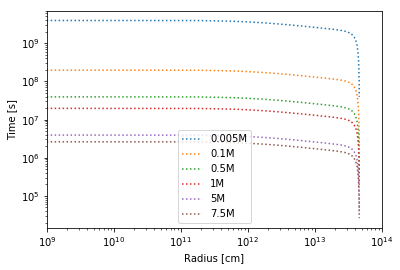

In [16]:
# test
from ipynb.fs.full.getProfiles import getMaxRadiusProfile
import matplotlib.pylab as plt

directory = '/Users/emilyflynn/Desktop/25M_tests/15M_logs'
p = getMaxRadiusProfile(directory)

m2s = [0.005, 0.1, 0.5, 1, 5, 7.5]

for i in range(len(m2s)):
    s = str(m2s[i]) + 'M'
    plotTInspiral(p, m2s[i], s)

plt.xlim(1e9, 1e14)

plt.xlabel('Radius [cm]')
plt.ylabel('Time [s]')

plt.legend()